In [1]:
import matplotlib.pyplot as plt
import nest as sim
import numpy as np
import pandas
from collections import Counter
import time as tm
import scipy.stats

sim.ResetKernel()

mins = 3.
sim_len = int(mins * 60000)
print(f'simulation length: {mins} mins = {sim_len} ms')

folder = 'whiskeye_head_direction_circling_distal_ideo_convnet_refined'

simulation length: 3.0 mins = 180000 ms


## Params

In [2]:
N_ex = 180
N_in = N_ex
N_cj = N_ex

sigma = 0.12
mu = 0.5
delay = 0.1
base_ex = 4000 #*N_ex
base_in = 450 #*N_in
base_cj = 169
w_ex_cj = 660

I_init = 300.0 #pA
I_init_dur = 100.0 #ms
I_init_pos = N_ex//2

## Create populations

In [3]:
exc = sim.Create("iaf_psc_alpha",N_ex, params={"I_e": 450.})
inh = sim.Create("iaf_psc_alpha",N_in)

l = sim.Create("iaf_psc_alpha",N_cj)
r = sim.Create("iaf_psc_alpha",N_cj)

## Define connections

In [4]:
# connections between excitatory and inhibitory rings
w_ex = np.empty((N_in,N_ex))
w_in = np.empty((N_ex,N_in))
for e in range(N_ex):
    for i in range(N_in):
        d1 = abs(e/N_ex - i/N_in)
        d2 = abs(e/N_ex - i/N_in -1)
        d3 = abs(e/N_ex - i/N_in +1)
        d = min(abs(d1),abs(d2),abs(d3))
        w_gauss = np.exp(-(d)**2/2/sigma**2)
        w_ring = np.exp(-(d - mu)**2/2/sigma**2)
        w_ex[i,e] = base_ex * w_gauss
        w_in[e,i] = base_in * w_ring 
            
w_ex[w_ex<10]=0
w_in[w_in<10]=0

In [5]:
# connections between conjuntive layers and excitatory ring
w_l = np.empty((N_ex,N_cj))
w_r = np.empty((N_ex,N_cj))
for c in range(N_cj):  
    for e in range(N_ex):
        d1 = abs((e-1)/N_cj - c/N_ex)
        d2 = abs((e-1)/N_cj - c/N_ex -1)
        d3 = abs((e-1)/N_cj - c/N_ex +1)
        d = min(abs(d1),abs(d2),abs(d3))
        w_l[e,c] = base_cj * (np.exp(-(d)**2/2/sigma**2))
        
        d1 = abs((e+1)/N_cj - c/N_ex)
        d2 = abs((e+1)/N_cj - c/N_ex -1)
        d3 = abs((e+1)/N_cj - c/N_ex +1)
        d = min(abs(d1),abs(d2),abs(d3))
        w_r[e,c] = base_cj * (np.exp(-(d)**2/2/sigma**2))
        
m = np.amax(w_l)
w_l[w_l<m] = 0
m = np.amax(w_r)
w_r[w_r<m] = 0

In [6]:
exc_2_inh = sim.Connect(exc,inh,'all_to_all',syn_spec={'weight': w_ex, 'delay': delay})
inh_2_exc = sim.Connect(inh,exc,'all_to_all',syn_spec={'weight': -w_in, 'delay': delay})

exc_2_l = sim.Connect(exc,l,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
exc_2_r = sim.Connect(exc,r,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})

l_2_exc = sim.Connect(l,exc,'all_to_all',syn_spec={'weight': w_l, 'delay': delay})
r_2_exc = sim.Connect(r,exc,'all_to_all',syn_spec={'weight': w_r, 'delay': delay})

## Record spike activity

In [7]:
exc_spikes = sim.Create("spike_detector", N_ex, params={"withgid": True,"withtime": True})
sim.Connect(exc,exc_spikes)

## Network input

### Odometry

In [8]:
file = folder.split('_')
if file[3] == 'random':
    file[3] = 'random_walk'
if file[5].isdigit():
    file = f'{file[3]}_{file[5]}_{file[4]}'
else:
    file = f'{file[3]}_{file[4]}'
posedata = pandas.read_csv(f'data/{file}.csv')

f = 50 #Hz
dt = int(1000/f)
theta = posedata['field.theta']
theta = np.array(theta)

angle_per_cell = (2*np.pi)/N_ex
I_init_pos = np.around((theta[0]//angle_per_cell)+(N_ex//2)).astype(int)

t = list(range(0,(len(theta)*dt),dt))
time = [i*1. for i in t if i < sim_len]
t = [i * 1. for i in t]

vel = np.diff(np.unwrap(theta))

circling_distal


In [9]:
Ivel = vel * 0.35 * 10000

sh = 150
go_l,go_r = Ivel,-Ivel
go_l = go_l+sh
go_r = go_r+sh
go_l[go_l<=sh] = 0
go_r[go_r<=sh] = 0

# Connect AV input to conjunctive layers
l_input = sim.Create('step_current_generator', 1)
sim.SetStatus(l_input,{'amplitude_times': t[1:],'amplitude_values': go_l})
r_input = sim.Create('step_current_generator', 1)
sim.SetStatus(r_input,{'amplitude_times': t[1:],'amplitude_values': go_r})

sim.Connect(r_input,r,'all_to_all')
sim.Connect(l_input,l,'all_to_all')

## PredNet predictions

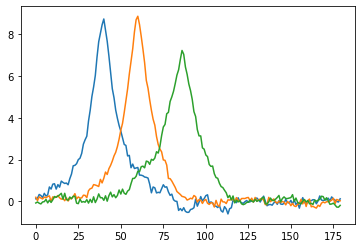

In [10]:
predtm = pandas.read_csv(f'data/{file}_frames.csv')
predNet = np.load(f'{folder}/visual/predictions_conv.npy')

predtm = np.array(predtm['%time'])
predtm = (predtm-predtm[0])/1000000

for p in range(len(predNet)):
    predNet[p] = (predNet[p])*10.
predNet = np.vstack([predNet,np.zeros([1,180])])

plt.plot(predNet[0])
plt.plot(predNet[50])
plt.plot(predNet[100])

predicitons = predNet[5:,:]
prediciton_times = predtm[5:len(predicitons)+5]

view_input = sim.Create('step_current_generator', N_ex)
for n in range(N_ex):
    sim.SetStatus([view_input[n]],{'amplitude_times': prediciton_times,'amplitude_values': predicitons[:,n]})
    
sim.Connect(view_input,exc,'one_to_one')

sim_len = prediciton_times[-1]
time = [i*1. for i in t if i < sim_len]

## Initialize bump

In [11]:
bump_init = sim.Create('step_current_generator', 1, params = {'amplitude_times':[0.1,0.1+I_init_dur],'amplitude_values':[I_init,0.0]})
sim.Connect(bump_init,[exc[I_init_pos]])

## Run simulation

In [12]:
tic = tm.time()
sim.Simulate(sim_len)
print(f'Simulation run time: {np.around(tm.time()-tic,2)} s  Simulated time: {np.around(sim_len/1000,2)} s')

Simulation run time: 198.92 s  Simulated time: 161.56 s


## Measure error

In [13]:
ev = sim.GetStatus(exc_spikes)[0]['events']
t = ev['times']
sp = ev['senders']

dt = 20
T = np.arange(0,(len(theta)*dt),dt*2)

modes = np.zeros(len(T))
modes[:] = np.nan
rates = np.zeros((N_ex,len(time)))
for i in range(len(T)-1):
    idx = (t>T[i])*(t<T[i+1])
    lst = sp[np.where(idx)]
    occurence_count = Counter(lst) 
    active = occurence_count.keys()
    for cell in active:
        rates[cell-1,i] = occurence_count[cell]
    mode = occurence_count.most_common(1)
    if len(mode):
        modes[i] = mode[0][0]
        
step = (2*np.pi)/N_ex
modes = (modes*step) - np.pi

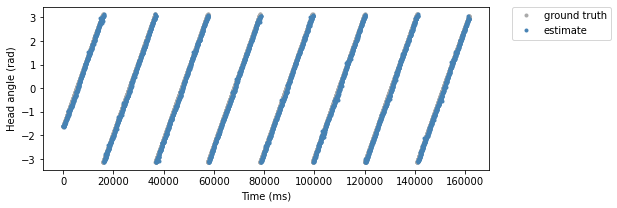

In [14]:
# fig, ax = plt.subplots(1, 1,figsize=(5, 3),facecolor='w')
fig, ax = plt.subplots(1, 1,figsize=(8, 3),facecolor='w')

shifted = modes-2.2
shifted[shifted>np.pi]=shifted[shifted>np.pi]-(np.pi*2)
shifted[shifted<-np.pi]=shifted[shifted<-np.pi]+(np.pi*2)
ax.plot(time,theta[:len(time)],'.',label='ground truth',color='darkgrey')
ax.plot(T,modes,'.',label='estimate',color='steelblue')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Head angle (rad)')

plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
plt.savefig(f'{folder}/drift.png')

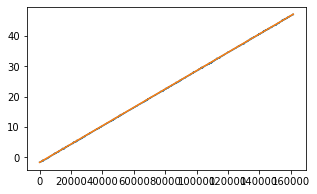

In [15]:
nanidx = np.where(~np.isnan(modes[:-1]))
modes = modes[nanidx]
T=T[nanidx]

est = np.unwrap(modes)
groundTruth = np.unwrap(theta[:len(time)])

estimate = np.interp(time, T, est)

hd_estimate = np.vstack([T,modes])
np.save(f'{folder}/estimate.npy',hd_estimate)

whiskeye_head_direction_circling_distal_ideo_convnet_refined
0.09072966612442987


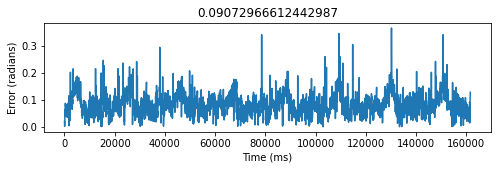

In [17]:
fig, ax = plt.subplots(1, 1,figsize=(8, 2),facecolor='w')

d = (groundTruth-estimate)
plt.plot(time,abs(d))
plt.xlabel('Time (ms)')
plt.ylabel('Error (radians)')

RMSE = np.sqrt(np.sum(d**2)/len(d))
print(folder)
print(RMSE)

plt.savefig(f'{folder}/error.png')